In [2]:

import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.utils import calc_total_error
import pandas as pd
from scipy.spatial import KDTree
import json


from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import math

In [3]:
%matplotlib inline

# Going to try debugging this one now

In [ ]:

   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }
#empty data frame to append values of flux to
rows=[]

In [ ]:
# Query the image catalog in the WISE database
#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }

M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
#extract a cutout for plotting and KDTree
wcs = WCS(image1[0].header)
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
wcs = cutout.wcs

#####   constants in every image:

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask



#####  End of constants










##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = image_data * non_overlapping_mask
                target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
            #filter only valid sources to conduct the overlapping photometry again. 
        # so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
        #valid_sources = display_data[display_data['Flag'] == 'Valid']

        for i, valid_row in display_data[display_data['Flag'] == 'Valid'].iterrows():
            x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
            target_aperture = CircularAperture((x, y), r)
            target_photo_table = aperture_photometry(image_data, target_aperture)
            target_counts = target_photo_table['aperture_sum'][0]
            
            if target_counts <= 0:
                target_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
                target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
                target_area = target_aperture.area

            non_overlapping_counts = target_counts

            for j, valid_row2 in display_data[display_data['Flag'] == 'Valid'].iterrows():
                if i != j:
                    x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
                    distance = dist((x, y), (x2, y2))
                    if distance < r + r2:
                        overlap_percent = (r + r2 - distance) / (r + r2)
                        if overlap_percent > .01: # i think i will have to fiddle around with this
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(image_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0]
                            #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                            non_overlapping_counts -= overlap_counts
                            

            if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
                net_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
                net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

            # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
            display_data.loc[i, 'Net Flux (Jy)'] = net_flux
            display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'

     
        
     ## Trying to plot the images now
     #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        #plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    





#rows.append({'band_id': {band_labels[band_id]},
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures

#for row in display_data.itertuples():
    #if row.Flag == 'Valid':
       # target_aperture = CircularAperture((row.X, row.Y), row.Radius)
       # annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
       # target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
       # annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)





# Just one band

In [ ]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
#for i in range(len(im_table)):
   # print(im_table[i])

In [ ]:
for i in range(len(im_table)):
    if im_table[i]['sia_bp_id']:

        print(im_table[i].getdataurl())

In [ ]:
data_url = im_table[0].getdataurl()
#Download the image and open it in Astropy
fname = download_file(data_url, cache=True)
image1= fits.open(fname)
image_data= image1[0].data
print(data_url)

In [ ]:
#grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
sources_7793


In [ ]:
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

hdr = image1[0].header
hdr


In [ ]:
#extract a cutout for plotting and KDTree
wcs = WCS(image1[0].header)
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
print(image_data.shape)
print(cutout.data.shape)
# THIS IS WHERE THE DISCREPANCY IS HAPPENING.
# When i make the image shape the same, the positions of the sources are almost identical to the 
# image downloaded code.
wcs = cutout.wcs
cutout_data = cutout.data

In [ ]:
#define the KDTree
# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 10

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)
# a problem could be with grouped postions maybe?
# here is where the code between downloading the image and using the URL differs!
#  the position of sources is slightly altered for some reason.

In [ ]:

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }

M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band
cutout_data.shape
grouped_positions


In [ ]:

# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target objects in the little aperture circle define their target apertures
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = cutout_data * non_overlapping_mask
        target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the target
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area

        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
        #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                   'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                     'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                       'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
    

#append the rows to the empty dataframe    
display_data = pd.DataFrame(rows)
display_data





#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()

display_data.loc[display_data['Flag']== 'Valid']



## dont think i need this 

In [ ]:


#filter only valid sources to conduct the overlapping photometry again. 
# so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(cutout_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                    non_overlapping_counts -= overlap_counts
                    

    if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
    display_data.loc[i, 'Net Flux (Jy)'] = net_flux
    display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'


#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()

display_data.loc[display_data['Flag']== 'Valid']
#display_data

# the new code for when i want to apply it to all wavelengths :

remember to include the code for different flux conversions for each band!!

In [ ]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }


In [ ]:
#DELETE THIS WHEN YOU HAVE PUT IN THE CONVERSION Code
M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

## dont use this

In [ ]:
cutout_alldata = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
       # print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data # maybe this needs to be assigned as a dictionary for each of them.
        cutout_alldata.append({ 'Band': {band_labels[band_id]}, 'CutoutData' : cutout_data, 'WCS': wcs})
cutout_alldata = pd.DataFrame(cutout_alldata)
cutout_alldata['ROI'] = np.nan
display(cutout_alldata)

#cutout_alldata = pd.DataFrame(columns=['Band', 'CutoutData', 'WCS'])  # Initialize with columns
#for i in [0, 3, 2, 1]:  # Reverse order index
  #  band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
   # if band_id in band_labels:
   #    # print(f'Band {band_labels[band_id]}: ')
    #    data_url = im_table[i].getdataurl()
   #     #Download the image and open it in Astropy
   #     fname = download_file(data_url, cache=True)
   #     image1= fits.open(fname)
    #    image_data= image1[0].data
        #print(data)
        
     #   wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
     #   cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
      #  wcs = cutout.wcs
      #  cutout_data = cutout.data # maybe this needs to be assigned as a dictionary for each of them.
      #  cutout_alldata.loc[len(cutout_alldata)] = [band_id, cutout_data, wcs]
        #cutout_alldata._append({ 'Band': {band_labels[band_id]}, 'CutoutData' : cutout_data, 'WCS': wcs}, ignore_index= True)

display(cutout_alldata)

for idx, row in cutout_alldata.iterrows():
    wcs = row.WCS
    positions = wcs.world_to_pixel_values(ra, dec)
    positions = np.array(list(zip(positions[0], positions[1])))

    #define the distance threshold for the KDTree grouping (in pixels)
    distance_threshold = 11

    #build the KDTree for efficient grouping
    tree = KDTree(positions)

    #query the KDTree to find points within the defined radius of dist threshold and group them together
    groups = tree.query_ball_tree(tree, r=distance_threshold)
    print(groups)
    # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
    unique_groups = []
    seen = set()
    for group in groups:
        group = tuple(sorted(group))
        if group not in seen:
            seen.add(group)
            unique_groups.append(group)
    print(unique_groups)
    # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
    #represents the consolidated postion of potentially multiple detections of one source.
    grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
    print(grouped_positions)

    #define the Region(s) Of Interest (center x, center y, radius)
    ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
    #empty data frame to append values of flux to
    roi_str = json.dumps(ROI) # to revert back : roi_list = json.loads(cutout_alldata.at[idx, 'ROI'])
    cutout_alldata.at[idx, 'ROI'] = roi_str
display(cutout_alldata)

for idx, row in cutout_alldata.iterrows(): 
    roi_list = json.loads(row['ROI'])
    band_id = row['Band']
    cutout_data = row['CutoutData']
    #now inputting the aperture photometry part
    # check for overlap and perform aperture photometry
    for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(roi_list):
        overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
        non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

        for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(roi_list): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
            if i != j: # ensures that a source is not compared to itself! wow
                distance = dist((x, y) , (x2, y2)) 
                if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                    overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                    if overlap_percent > .5:
                        overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                        break
                    else: 
                        overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                        non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                        # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                        # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                    
        if overlap:
            #flag the sources that overlap
            rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
        else: #perform all the aperture photometry stuff
            # For the Target objects in the little aperture circle define their target apertures
            target_aperture = CircularAperture((x,y),r,)
        
            #perform aperture photometry on target
            # also now apply the masked data
            masked_data = cutout_data * non_overlapping_mask
            target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
            target_counts = target_photo_table['aperture_sum'][0]

            if target_counts<= 0: # 
                target_flux # avoid taking the log of zero or negative value
            else:
                    #counts to flux
                Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                #calculate area of annulus
            target_area = target_aperture.area



            # For the Background Annuli of outside of the Target
            #define the background annulus for the target
            annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

            #perform aperture photometry on annuli
            annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
            annulus_counts = annulus_photo_table['aperture_sum'][0]
        
            if annulus_counts <= 0:
                annulus_flux = 0  # Avoid taking log of zero or negative value
            else:
                #counts to flux
                Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

            #calculate area of annulus
            annulus_area = annulus_aperture.area

            # do the calculations for including a Background aperture
        
            #Calculating the net flux:
            #calculate the mean background per pixel
            bg_perpixel = annulus_flux/annulus_area

            #calculate the total background in the target aperture
            tot_bg = bg_perpixel * target_area

            #Subtract background from the target flux
            net_flx = target_flux - tot_bg
        
            #   Append the result as a dictionary to the list named 'rows'
            rows.append({ 'band_id': band_id,'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                    'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                    'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                        'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                        'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
        #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
    
display_data = pd.DataFrame(rows)
display(display_data)

fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()


## maybe

In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        print(data_url)
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cutting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data

        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 10

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        #empty data frame to append values of flux to


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
     
    
     ## Trying to plot the images now
        

display_data = pd.DataFrame(rows)
display_data

for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    








display(display_data)
#display(display_data.loc[display_data['Flag']== 'Valid'])
#pd.set_option("display.max_rows", None)



# best versions of the code so far


## good but has too many duplicates

In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
     
    
     ## Trying to plot the images now
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in rows:
            if row['Flag'] == 'Valid':
                target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
                annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        

display_data = pd.DataFrame(rows)
display_data




    









display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
pd.set_option("display.max_rows", None)



## 2nd best version of code
fixed duplicates, does not yet have overlap subtraction in it

In [ ]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }


In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        target_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.

                    
                    #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts > 0:
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                })
                
            # Append valid_rows to rows (if needed for overall storage)
            #rows.extend(valid_rows)
        print('valid rows', valid_rows)

    # Plotting for current image
    # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']),
                                            row['Annulus_Inner_Radius'],
                                            row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
        ax.imshow(cutout.data, cmap='gray', norm=norm)
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()

display_data = pd.DataFrame(rows)
display_data




    









display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
#pd.set_option("display.max_rows", None)



## BEST VERSION OF THE CODE
put the overlapping SUBTRACTION code into it

In [ ]:
####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }


In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0]
                            target_counts -= overlap_counts


            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        target_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.

                    
                    #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts > 0:
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                })
                
            # Append valid_rows to rows (if needed for overall storage)
            #rows.extend(valid_rows)
        #print('valid rows', valid_rows)

    # Plotting for current image
    # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']),
                                            row['Annulus_Inner_Radius'],
                                            row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
        ax.imshow(cutout.data, cmap='gray', norm=norm)
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        

display_data = pd.DataFrame(rows)
display_data
pd.set_option("display.max_rows", 30)
display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)




# Including source detection

In [ ]:
'''
error was calculated by determining the error from the annuli and overlapping areas,

'''





####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }

'''REMEMBER TO
Convert the sensitivities from jy to dn and then back to jy after running it through aperture photometry
'''
#noise_level =  {'w1': 0.0000136,'w2': 0.0000196,'w3': 0.000172 ,'w4': 0.00108 } THIS IS IN Jy. convert it to DN:
noise_level =  {'w1': 8.6, 'w2': 7.607, 'w3': 59.54229 , 'w4': 20.093 }


#flux uncertainty
#bkg_error = annulus_error_var
#overlap_error = overlap_error_var

#error = calculate_total_error(data, bkg_error, overlapping counts? yes easy)
#_error_var = _photo_table['aperture_sum_err'][0]
tot_err= []
def calc_tot_err(target_error_var, annulus_error_var, overlap_error_var):
     tot_err = np.sqrt(target_error_var**2 + annulus_error_var**2 + overlap_error_var**2)
     return tot_err
     
def create_error_array(shape, noise_level):
     #creates an error array with a constant noise level, although this makes me wonder about what to do for areas of brightness or if that doesnt matter.
     return np.full(shape, noise_level)

     
# 'Target Error': target_error_var, 'Annulus Error': annulus_error_var, 'Overlap Error': overlap_error_var










#initiate dict for the std of each image
cutout_std =  {'w1': [], 'w2': [], 'w3': [], 'w4': []}

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase

    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []
        
        #calculate the std of each cutout image to then be used for determining the error in the flux derivations
        if band_id in cutout_std:
            mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)
            cutout_std[band_id].append(std)
            print(cutout_std)

        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            if band_id in noise_level and cutout_std:
                                 band_noise_level = noise_level[band_id]
                                 band_std = cutout_std[band_id] 
                                 error = create_error_array(cutout_data.shape, band_noise_level)
                                 error2 = create_error_array(cutout_data.shape, band_std)     ## using error2 seems to give the best estimation of uncertainty for the Flux values.
                                 overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture, error=error2)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error_var = overlap_photo_table['aperture_sum_err'][0]
                            #print(overlap_error_var)
                            if target_counts > 0:
                                target_counts -= overlap_counts
                            
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            if band_id in noise_level and cutout_std:
                                band_noise_level = noise_level[band_id]
                                band_std = cutout_std[band_id]
                                error = create_error_array(cutout_data.shape, band_noise_level)
                                error2 = create_error_array(cutout_data.shape, band_std)
                                overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture, error=error2)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error_var = overlap_photo_table['aperture_sum_err'][0]
                            #print(overlap_error_var)
                            if target_counts > 0:
                                target_counts -= overlap_counts
                            


            if overlap:
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                if band_id in noise_level and cutout_std:
                    band_noise_level = noise_level[band_id]
                    band_std = cutout_std[band_id]
                    error = create_error_array(cutout_data.shape, band_noise_level)
                    error2 = create_error_array(cutout_data.shape, band_std)
                    target_photo_table = aperture_photometry(cutout_data, target_aperture, error=error2) 
                target_counts = target_photo_table['aperture_sum'][0]
                target_error_var = target_photo_table['aperture_sum_err'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [], 'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [],  'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_error_var, 'Annulus Error': annulus_error_var, 'Overlap Error': overlap_error_var})

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                if band_id in noise_level and cutout_std:
                    band_noise_level = noise_level[band_id]
                    band_std = cutout_std[band_id]
                    error = create_error_array(cutout_data.shape, band_noise_level)
                    error2 = create_error_array(cutout_data.shape, band_std)
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture, error=error2)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                annulus_error_var = annulus_photo_table['aperture_sum_err'][0]
            
                if annulus_counts > 0:
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #flag the sources that overlap
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': [], 'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_error_var, 'Annulus Error': annulus_error_var, 'Overlap Error': overlap_error_var })
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [],'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                    'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_error_var, 'Annulus Error': annulus_error_var, 'Overlap Error': overlap_error_var })
                
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                if band_id in noise_level and cutout_std:
                    band_noise_level = noise_level[band_id]
                    band_std = cutout_std[band_id]
                    error = create_error_array(cutout_data.shape, band_noise_level)
                    error2 = create_error_array(cutout_data.shape, band_std)
                    target_photo_table = aperture_photometry(cutout_data, target_aperture, error=error2) 
                target_counts = target_photo_table['aperture_sum'][0]
                target_error_var = target_photo_table['aperture_sum_err'][0]
                

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': [],'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_error_var, 'Annulus Error': annulus_error_var, 'Overlap Error': overlap_error_var})

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                if band_id in noise_level and cutout_std:
                    band_noise_level = noise_level[band_id]
                    band_std = cutout_std[band_id]
                    error = create_error_array(cutout_data.shape, band_noise_level)
                    error2 = create_error_array(cutout_data.shape, band_std)
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                annulus_error_var = annulus_photo_table['aperture_sum_err'][0]
                
            
                if annulus_counts > 0:
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [],  'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                              'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_error_var, 'Annulus Error': annulus_error_var, 'Overlap Error': []})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [],
                    'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 
                    'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                     'Target Error': target_error_var, 'Annulus Error': annulus_error_var, 'Overlap Error': [] })


        #Source detection code
        mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)  
       #print((mean, median, std))

        # subtract the background and find FWHM of sources at a certain threshold
        #started at fwhm= 3 and threshold = 5
        daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
        sources = daofind(cutout_data - median)  
        #print(type(sources))
        # will likely run into iissues in the code below
        for col in sources.colnames:  
            if col not in ('id', 'npix'):
                sources[col].info.format = '%.2f'  # for consistent table output
       # sources.pprint(max_width=3000)  

        #likely the flux labeled in this is not converted!
        
        # plot the image with marked locations of all the sources it detected.
        detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(detected_positions, r=2)


        # Plotting for current image
        # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        
        # Was there a point source there?
        pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
        detectedpos_all = []
        #rows = [row for row in rows if row['Flag'] == 'Valid']
        for row in valid_rows_filtered:
            apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
            for detected_position in detected_positions:
                detected_x, detected_y = detected_position
                distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                if distance <= row['Radius']: 
                    row['Exists?'] = 'Point Source Detected'
                    row['Point Source Position'].append((detected_x, detected_y))
                    dist_in_arc = distance * pixelsinarc
                    row['Offset in Arcseconds'].append((dist_in_arc))
                    detectedpos_all.append(detected_position) 
                    #print(f"Number of detected positions within forced apertures: {len(detectedpos_all)}")


        Yes = []
        YesRadius= 5
        for row in valid_rows_filtered:
                    apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                    for detected_position in detected_positions:
                        detected_x, detected_y = detected_position
                        distance = dist((row['X'], row['Y']), (detected_x, detected_y) )

                        if distance <= YesRadius:
                            row['Exists?'] = 'Yes!!'
                            Yes.append((row['X'], row['Y']))
                 
        #calculate error, convert it back to flux and append the total error
        #total_error = np.sqrt(target_error_var**2 + annulus_error_var**2 + overlap_error_var**2)
        for row in valid_rows_filtered:
            #print(row['Overlap Error'])
            if row['Overlap Error']:  # Check if the list is not empty
                overlap_error_var = row['Overlap Error']  
            else:
                overlap_error_var = 0  # Use 0 if the list is empty
            total_error = np.sqrt(target_error_var**2 + annulus_error_var**2 + overlap_error_var**2)
            if band_id in flux_zmfd and instr_zpmag: 
                flx_conv_fact = flux_zmfd[band_id]
                M0instr = instr_zpmag[band_id]
                Mcal_error = M0instr - 2.5*(np.log10(total_error))     #converting counts to magnitude
                total_error_flx = flx_conv_fact * 10**(Mcal_error/-2.5)#convert Magnitude to Flux
                flux_uncertainty_value = total_error_flx      #may need to index the variable here.
                #print(f'Total error in flux for band {band_id}: {flux_uncertainty_value}')
                row['Flux Uncertainty'].append(flux_uncertainty_value)
            else:
                 print(f'Missing data for band {band_id}. Skipping...')
                             

        # Update rows with valid_rows_filtered information
        for valid_row in valid_rows_filtered:
            for row in rows:
                if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                    row.update(valid_row)

        #print('valid sources', valid_rows_filtered)

        #print( len(detectedpos_all))
        if len(detectedpos_all) > 0:
            apertures_detected = CircularAperture(detectedpos_all, r=2)
        if len(Yes) > 0:
            apertures_Yes = CircularAperture(Yes, r=YesRadius)



         # Plotting for current image
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
            
            apertures.plot(color='#98ff98', lw=.5, alpha=0.5) 
            apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
            apertures_Yes.plot(color='green', lw=.5, alpha=0.5) 
        ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        

display_data = pd.DataFrame(rows)
display_data
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(len(display_data.loc[display_data['Flag']== 'Valid']))
print(len(display_data))
display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))



# Propagating uncertainty correctly

In [ ]:
'''
error was calculated by determining the error from the annuli and overlapping areas,

'''



####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase

    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []
        
        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask))
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
            if overlap:
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]
                target_counts -= overlap_counts

                # so that i dont take the log or sqrt of a negative number or zero and get an error
                if target_counts > 0: # 
                    target_error= np.sqrt(target_counts)
                    #propagated error of overlap error
                    target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                    #print(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                         
                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [], 'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [],  'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error })

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                
            
                if annulus_counts > 0:
                    overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                     # to avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)


                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
            
                #flag the sources that overlap
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error})
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                    'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error})
                
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    target_error = np.sqrt(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': [],'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error})

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                # the error of the annulus for sources that overlap
                
                if annulus_counts > 0:
                    annulus_error = np.sqrt(annulus_counts)
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
               #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!

                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                              'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': []})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                    'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 
                    'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                     'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': []})


        #Source detection code
        mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)  
       #print((mean, median, std))

        # subtract the background and find FWHM of sources at a certain threshold
        #started at fwhm= 3 and threshold = 5
        daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
        sources = daofind(cutout_data - median)  
        #print(type(sources))
        # will likely run into iissues in the code below
        for col in sources.colnames:  
            if col not in ('id', 'npix'):
                sources[col].info.format = '%.2f'  # for consistent table output
       # sources.pprint(max_width=3000)  

        #likely the flux labeled in this is not converted!
        
        # plot the image with marked locations of all the sources it detected.
        detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(detected_positions, r=2)


        # Plotting for current image
        # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        
        # Was there a point source there?
        pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
        detectedpos_all = []
        #rows = [row for row in rows if row['Flag'] == 'Valid']
        for row in valid_rows_filtered:
            apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
            for detected_position in detected_positions:
                detected_x, detected_y = detected_position
                distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                if distance <= row['Radius']: 
                    row['Exists?'] = 'Point Source Detected'
                    row['Point Source Position'].append((detected_x, detected_y))
                    dist_in_arc = distance * pixelsinarc
                    row['Offset in Arcseconds'].append((dist_in_arc))
                    detectedpos_all.append(detected_position) 
                    #print(f"Number of detected positions within forced apertures: {len(detectedpos_all)}")


        Yes = []
        YesRadius= 5
        for row in valid_rows_filtered:
                    apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                    for detected_position in detected_positions:
                        detected_x, detected_y = detected_position
                        distance = dist((row['X'], row['Y']), (detected_x, detected_y) )

                        if distance <= YesRadius:
                            row['Exists?'] = 'Yes!!'
                            Yes.append((row['X'], row['Y']))
                 
        
        # Update rows with valid_rows_filtered information
        for valid_row in valid_rows_filtered:
            for row in rows:
                if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                    row.update(valid_row)

        #print('valid sources', valid_rows_filtered)

        #print( len(detectedpos_all))
        if len(detectedpos_all) > 0:
            apertures_detected = CircularAperture(detectedpos_all, r=2)
        if len(Yes) > 0:
            apertures_Yes = CircularAperture(Yes, r=YesRadius)
        
       # xc = 244.422687	 #19.014239	
       # yc=  191.596758# 310.340772
    

         # Plotting for current image
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
            
            apertures.plot(color='#98ff98', lw=.5, alpha=0.5) 
            apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
            apertures_Yes.plot(color='green', lw=.5, alpha=0.5) 

            # curious ones
           # curious = CircularAperture((xc,yc),5)
           # curious.plot(color='red', lw=.5, alpha=0.5)
        ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()

        
        

display_data = pd.DataFrame(rows)
display_data
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(len(display_data.loc[display_data['Flag']== 'Valid']))
print(len(display_data))
display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))



In [ ]:
# I want a csv version of this too
for column in display_data.columns:
    if display_data[column].apply(lambda x: isinstance(x, set)).any():
        display_data[column] = display_data[column].apply(lambda x: str(x))
for column in display_data.columns:
    if display_data[column].apply(lambda x: isinstance(x, list)).any():
        display_data[column] = display_data[column].apply(lambda x: str(x))

data = display_data.loc[display_data['Flag']== 'Valid']

data_out = Table.from_pandas(data)
output_path = '../Data/Flux_uncs.csv'

# Write the table in csv format
data_out.write(output_path, format='csv')

In [ ]:
yes_sources = display_data.loc[display_data['Exists?']== 'Yes!!']
#display(yes_sources)
#3.4, 4.6, 12, and 22
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}
#define function to get flux density by dividing it by the wavelength
def flux_dens(net_flx, net_flx_err, wavelength):
    flux_density = net_flx / wavelength
    flux_density_unc = net_flx_err / wavelength
    flux_density_and_uncertainty = flux_density, flux_density_unc
    return flux_density_and_uncertainty 

for band_label in band_labels:
    wavelength = wavelengths[band_label]
    flux_density, flux_density_unc = flux_dens(yes_sources['Net Flux (Jy)'], yes_sources['Flux Uncertainty'], wavelength)
    # plot flux density vs wavelength
    if band_label in band_labels:
        print(f'Band {band_labels[band_label]}: ')
        plt.plot(wavelength, flux_density)










    
    

    




# Incorporating SED

<SkyCoord (ICRS): (ra, dec) in deg
    (359.457, -32.592)>
('W4 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits', '{"aws": {"bucket_name": "nasa-irsa-wise", "key":"wise/allwise/images/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits", "region": "us-west-2"}}', 2, 'image/fits', 0.0, -33.317778, array([4095, 4095], dtype=int32), array([2048., 2048.]), array([  0.      , -33.317778]), 'SIN', array([-0.00038194,  0.00038194]), array([-0.00038194, -0.        , -0.        ,  0.00038194]), 'W4', 2.209e-05, 2.336e-05, 1.984e-05, 'm', 13.0, 0.012, 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-unc-3.fits.gz', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-cov-3.fits.gz', '0000m334_ac51')
('W1 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_97832/146619933.py:32: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')


Band W4: 
{'X': 244.42268676214448, 'sources': [{'band_id': {'W4'}, 'Region': 11, 'X': 244.42268676214448, 'Y': 191.59675766724166, 'Radius': 9, 'Annulus_Inner_Radius': 16, 'Annulus_Outer_Radius': 23, 'Net Flux (Jy)': 0.012302686365658566, 'Flux Uncertainty': 0.011980261012624747, 'Flag': 'Valid', 'Flux Conv': 8.363, 'MzpInstr': 12.98, 'Exists?': 'Yes!!', 'Point Source Position': [(243.3789797697625, 192.1648220806889)], 'Offset in Arcseconds': [1.6338919810711983], 'Target Error': 0.010527920549028723, 'Annulus Error': 0.019270014955713115, 'Overlap Error (in counts)': [], 'Wavelength': 22}]}
[{'X': 244.42268676214448, 'sources': [{'band_id': {'W4'}, 'Region': 11, 'X': 244.42268676214448, 'Y': 191.59675766724166, 'Radius': 9, 'Annulus_Inner_Radius': 16, 'Annulus_Outer_Radius': 23, 'Net Flux (Jy)': 0.012302686365658566, 'Flux Uncertainty': 0.011980261012624747, 'Flag': 'Valid', 'Flux Conv': 8.363, 'MzpInstr': 12.98, 'Exists?': 'Yes!!', 'Point Source Position': [(243.3789797697625, 192.

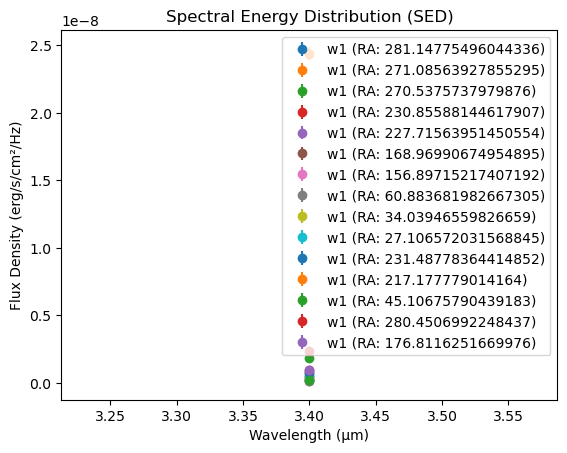

109
780


,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flux Uncertainty,Flag,...,Flux Conv,MzpInstr,Offset in Arcseconds,Exists?,Point Source Position,Target Error,Annulus Error,Overlap Error (in counts),Wavelength,Overlap Counts
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,0.0119,Valid,...,8.363,12.98,[],No,[],0.010450,0.019185,[],22.0,NaN
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,0.011908,Valid,...,8.363,12.98,[],No,[],0.010457,0.019198,[],22.0,NaN
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,0.011908,Valid,...,8.363,12.98,[],No,[],0.010457,0.019197,[],22.0,NaN
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,0.011898,Valid,...,8.363,12.98,[],No,[],0.010449,0.019181,[],22.0,NaN
5,{W4},6,281.147755,141.030790,9,16,23,0.000976,0.01191,Valid,...,8.363,12.98,[8.399903121792557],Point Source Detected,"[(284.4256549340734, 135.87564640212466)]",0.010459,0.019198,[],22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,{W1},98,45.106758,76.526072,9,16,23,0.000095,0.000051,Valid,...,309.540,20.73,[0.13314894931077426],Yes!!,"[(45.09266689385177, 76.43026714395607)]",0.000045,0.000079,[],3.4,NaN
741,{W1},101,280.450699,154.977536,9,16,23,0.000379,0.000079,Valid,...,309.540,20.73,[1.4941432504076897],Yes!!,"[(279.4221204071491, 155.32801135543508)]",0.000071,0.000121,[],3.4,NaN
747,{W1},105,210.918926,313.028816,9,16,23,0.000340,0.000072,Valid,...,309.540,20.73,[9.026981159085102],Point Source Detected,"[(211.36168276583106, 306.4786856354707)]",0.000064,0.000110,[],3.4,NaN
750,{W1},107,203.923577,174.000270,9,16,23,0.000250,0.000105,Valid,...,309.540,20.73,"[9.01432165988941, 8.031545111738401]",Point Source Detected,"[(197.4201197622296, 174.82760018217965), (208...",0.000092,0.000166,[],3.4,NaN


,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flux Uncertainty,Flag,...,Flux Conv,MzpInstr,Offset in Arcseconds,Exists?,Point Source Position,Target Error,Annulus Error,Overlap Error (in counts),Wavelength,Overlap Counts
0,{W4},1,438.545629,85.376843,9,16,23,-0.223282,0.007353,Low Flux,...,8.363,12.98,[],No,[],0.006241,0.013104,[],22.0,NaN
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,0.0119,Valid,...,8.363,12.98,[],No,[],0.010450,0.019185,[],22.0,NaN
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,0.011908,Valid,...,8.363,12.98,[],No,[],0.010457,0.019198,[],22.0,NaN
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,0.011908,Valid,...,8.363,12.98,[],No,[],0.010457,0.019197,[],22.0,NaN
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,0.011898,Valid,...,8.363,12.98,[],No,[],0.010449,0.019181,[],22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,{W1},121,314.489189,59.443072,9,16,23,-0.000209,0.000052,Low Flux,...,309.540,20.73,[],No,[],0.000045,0.000089,[],3.4,NaN
776,{W1},122,242.358645,-86.486904,9,16,23,-0.000209,[],Negative Target Counts,...,309.540,20.73,[],No,[],0.000045,0.000089,NaN,3.4,NaN
777,{W1},122,242.358645,-86.486904,9,16,23,NaN,0.000052,Low Flux,...,309.540,20.73,[],No,[],0.000045,0.000089,[],3.4,NaN
778,{W1},123,132.209797,199.605292,9,16,23,-0.003682,0.000091,Low Flux,...,309.540,20.73,[],No,[],0.000080,0.000147,48.224944,3.4,2325.645203


109


In [63]:
'''
error was calculated by determining the error from the annuli and overlapping areas,

'''



####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}

#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
    flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
    flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
    return flux_density, flux_density_unc


##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase

    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []
        
        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask))
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
            if overlap:
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]
                target_counts -= overlap_counts

                # so that i dont take the log or sqrt of a negative number or zero and get an error
                if target_counts > 0: # 
                    target_error= np.sqrt(target_counts)
                    #propagated error of overlap error
                    target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                    #print(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                         
                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [], 'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [],  'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id] })

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                
            
                if annulus_counts > 0:
                    overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                     # to avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)


                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
            
                #flag the sources that overlap
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id]})
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                    'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id]})
                
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    target_error = np.sqrt(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': [],'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id]})

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                # the error of the annulus for sources that overlap
                
                if annulus_counts > 0:
                    annulus_error = np.sqrt(annulus_counts)
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
               #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!

                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                              'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id]})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                    'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 
                    'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                     'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id] })


        #Source detection code
        mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)  
       #print((mean, median, std))

        # subtract the background and find FWHM of sources at a certain threshold
        #started at fwhm= 3 and threshold = 5
        daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
        sources = daofind(cutout_data - median)  
        #print(type(sources))
        # will likely run into iissues in the code below
        for col in sources.colnames:  
            if col not in ('id', 'npix'):
                sources[col].info.format = '%.2f'  # for consistent table output
       # sources.pprint(max_width=3000)  

        #likely the flux labeled in this is not converted!
        
        # plot the image with marked locations of all the sources it detected.
        detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(detected_positions, r=2)


        # Plotting for current image
        # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        
        # Was there a point source there?
        pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
        detectedpos_all = []
        #rows = [row for row in rows if row['Flag'] == 'Valid']
        for row in valid_rows_filtered:
            apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
            for detected_position in detected_positions:
                detected_x, detected_y = detected_position
                distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                if distance <= row['Radius']: 
                    row['Exists?'] = 'Point Source Detected'
                    row['Point Source Position'].append((detected_x, detected_y))
                    dist_in_arc = distance * pixelsinarc
                    row['Offset in Arcseconds'].append((dist_in_arc))
                    detectedpos_all.append(detected_position) 
                    #print(f"Number of detected positions within forced apertures: {len(detectedpos_all)}")


        Yes = []
        YesRadius= 5
        for row in valid_rows_filtered:
                    apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                    for detected_position in detected_positions:
                        detected_x, detected_y = detected_position
                        distance = dist((row['X'], row['Y']), (detected_x, detected_y) )

                        if distance <= YesRadius:
                            row['Exists?'] = 'Yes!!'
                            Yes.append((row['X'], row['Y']))
                 
        
        # Update rows with valid_rows_filtered information
        for valid_row in valid_rows_filtered:
            for row in rows:
                if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                    row.update(valid_row)

        #print('valid sources', valid_rows_filtered)

        #print( len(detectedpos_all))
        if len(detectedpos_all) > 0:
            apertures_detected = CircularAperture(detectedpos_all, r=2)
        if len(Yes) > 0:
            apertures_Yes = CircularAperture(Yes, r=YesRadius)
        
       # xc = 244.422687	 #19.014239	
       # yc=  191.596758# 310.340772
    

         # Plotting for current image
        #fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        #norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        #for row in valid_rows_filtered:
         #  target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
          #  annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
           # target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
          #  annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
            
           # apertures.plot(color='#98ff98', lw=.5, alpha=0.5) 
           # apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
           # apertures_Yes.plot(color='green', lw=.5, alpha=0.5) 

            # curious ones
           # curious = CircularAperture((xc,yc),5)
           # curious.plot(color='red', lw=.5, alpha=0.5)
       # ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
       # ax.set_xlabel('Right Ascension')
       # ax.set_ylabel('Declination')
       # plt.title(f'Band {band_labels[band_id]}')
       # plt.show()
        yesses =[row for row in valid_rows_filtered if row['Exists?'] == 'Yes!!']
        #print(yesses)
        
        sources_by_ra = []
        for row in yesses:
            right_asc = row['X']
            # Find the RA group in the list
            ra_group = next((item for item in sources_by_ra if item['X'] == right_asc), None)
            if ra_group is None:
                # If the RA group doesn't exist, create a new one
                ra_group = {'X': right_asc, 'sources': []}
                sources_by_ra.append(ra_group)
            # Append the current row to the corresponding RA group
            ra_group['sources'].append(row)
            print(ra_group)
            print(sources_by_ra)

# Creating SED plots
plt.figure()

# Loop through grouped sources by RA
for ra_group in sources_by_ra:
    right_asc = ra_group['X']
    for source in ra_group['sources']:
        net_flx = source['Net Flux (Jy)']
        net_flx_err = source['Flux Uncertainty']
        wavelength = source['Wavelength']
        flux_density, flux_density_unc = flux_dens(net_flx, net_flx_err, wavelength)
        
        # Plot flux density vs wavelength using plt.errorbar
        plt.errorbar(wavelength, flux_density, yerr=flux_density_unc, fmt='o', label=f'{band_id} (RA: {right_asc})')
# Set plot labels and title
plt.xlabel('Wavelength (µm)')
plt.ylabel('Flux Density (erg/s/cm²/Hz)')
plt.title('Spectral Energy Distribution (SED)')
plt.legend()
plt.show()





'''
#code here does not quite work
        # group sources by ra
        sources_by_ra = {}
        for row in yesses:
             #extract the ra value from the current row
            right_asc= row['X']
             # if this Ra value is not already a key for which you can organize the bands under, add it to the dictionary and initialize the values under it as empty so that you can append the information from "yesses" into it.
            if right_asc not in sources_by_ra:
                sources_by_ra[right_asc] = []
                #append the information of from each band that associates with that RA value
            sources_by_ra[right_asc].append(row)
            print(sources_by_ra)

#creating SED plots
plt.figure()

# now plot sources by their RA values
for right_asc, sources in sources_by_ra.items():
    for source in sources:
        net_flx1 = source['Net Flux (Jy)']
        net_flx_err1 = source ['Flux Uncertainty']
        #print(net_flx1)
        #print(net_flx_err1)
        wavelength = source['Wavelength']
        flux_density, flux_density_unc = flux_dens(net_flx1, net_flx_err1, wavelength)
        #now, if the postion of a source in one band is the same as another band, plot their flux densities on the same graph.
        
        # plot flux density vs wavelength
        plt.errorbar(wavelength, flux_density, yerr = flux_density_unc, fmt='o', label=f"{source['band_id']} (RA: {right_asc})")
plt.xlabel('Wavelength (µm)')
plt.ylabel('Flux Density (erg/s/cm²/Hz)')
plt.title('Spectral Energy Distribution (SED)')
plt.legend()
plt.show()
'''

       

        
        



display_data = pd.DataFrame(rows)
display_data
#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
print(len(display_data.loc[display_data['Flag']== 'Valid']))
print(len(display_data))
display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))

